In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

import plotly.express as px

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings("ignore")

import os
project_root = os.path.abspath('..')

import sys
sys.path.append(project_root)

In [2]:
from src.data import *
from src.features import *
from src.models import *
from src.utils.constants import DEFAULT_TEXT_COLUMN, DEFAULT_TARGET_COLUMN, METAFEATURES


In [3]:
# Load data
df_train, df_test = load_data()

# Delete ID columns
id_train, id_test, df_train, df_test = process_ids(df_train, df_test)

# Display data info
display_data_info(df_train, df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.0+ KB


,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   3237 non-null   object
 1   location  2158 non-null   object
 2   text      3263 non-null   object
dtypes: object(3)
memory usage: 76.6+ KB


,keyword,location,text
0,NaN,NaN,Just happened a terrible car crash
1,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Handle Duplicates

In [4]:
# Remove duplicates from train dataset
df_train, removed_count = remove_duplicates(df_train)
print(f"Removed {removed_count} duplicate rows")

Removed 52 duplicate rows


### Keyword and Location Features Analysis

In [5]:
# Print basic info about keyword and location columns
print_keyword_location_analysis_results(df_train, df_test)

Missing Values Analysis:

TRAIN:
keyword: 0.81%

TRAIN:
text: 0.00%

TRAIN:
location: 33.06%

TEST:
keyword: 0.80%

TEST:
text: 0.00%

TEST:
location: 33.86%

Unique Values Analysis:
train_keyword_unique: 221
train_location_unique: 3341
test_keyword_unique: 221
test_location_unique: 1602



After filling missing values:

Keyword counts (top 10):
keyword
no_keyword     61
fatalities     45
deluge         42
armageddon     42
damage         41
harm           41
body%20bags    41
sinking        40
evacuate       40
fear           40
Name: count, dtype: int64

Location counts (top 10):
location
no_location        2500
USA                 104
New York             71
United States        50
London               45
Canada               29
UK                   27
Los Angeles, CA      26
India                23
Nigeria              23
Name: count, dtype: int64


### Target Distribution

From the plot below we can see, that there is a moderate class disbalance in target column. That's why we will use stratified approaches to model evaluation.

In [6]:
target_counts = df_train['target'].value_counts().reset_index()
target_counts.columns = ['target', 'count']

fig = px.pie(target_counts, 
             values='count', 
             names='target',
             title='Target Distribution',
             color_discrete_sequence=px.colors.sequential.Rainbow)

fig.update_traces(textposition='inside', 
                  textinfo='percent+label',
                  pull = [0.1, 0, 0, 0],
                  marker = dict(line = dict(color = '#000000', width = 1)))

fig.update_layout(
    title_font_size = 24,
    uniformtext_minsize = 12,
    uniformtext_mode = 'hide',
    height = 600,
    width = 600
)

fig.show()

### Numerical featute engineering

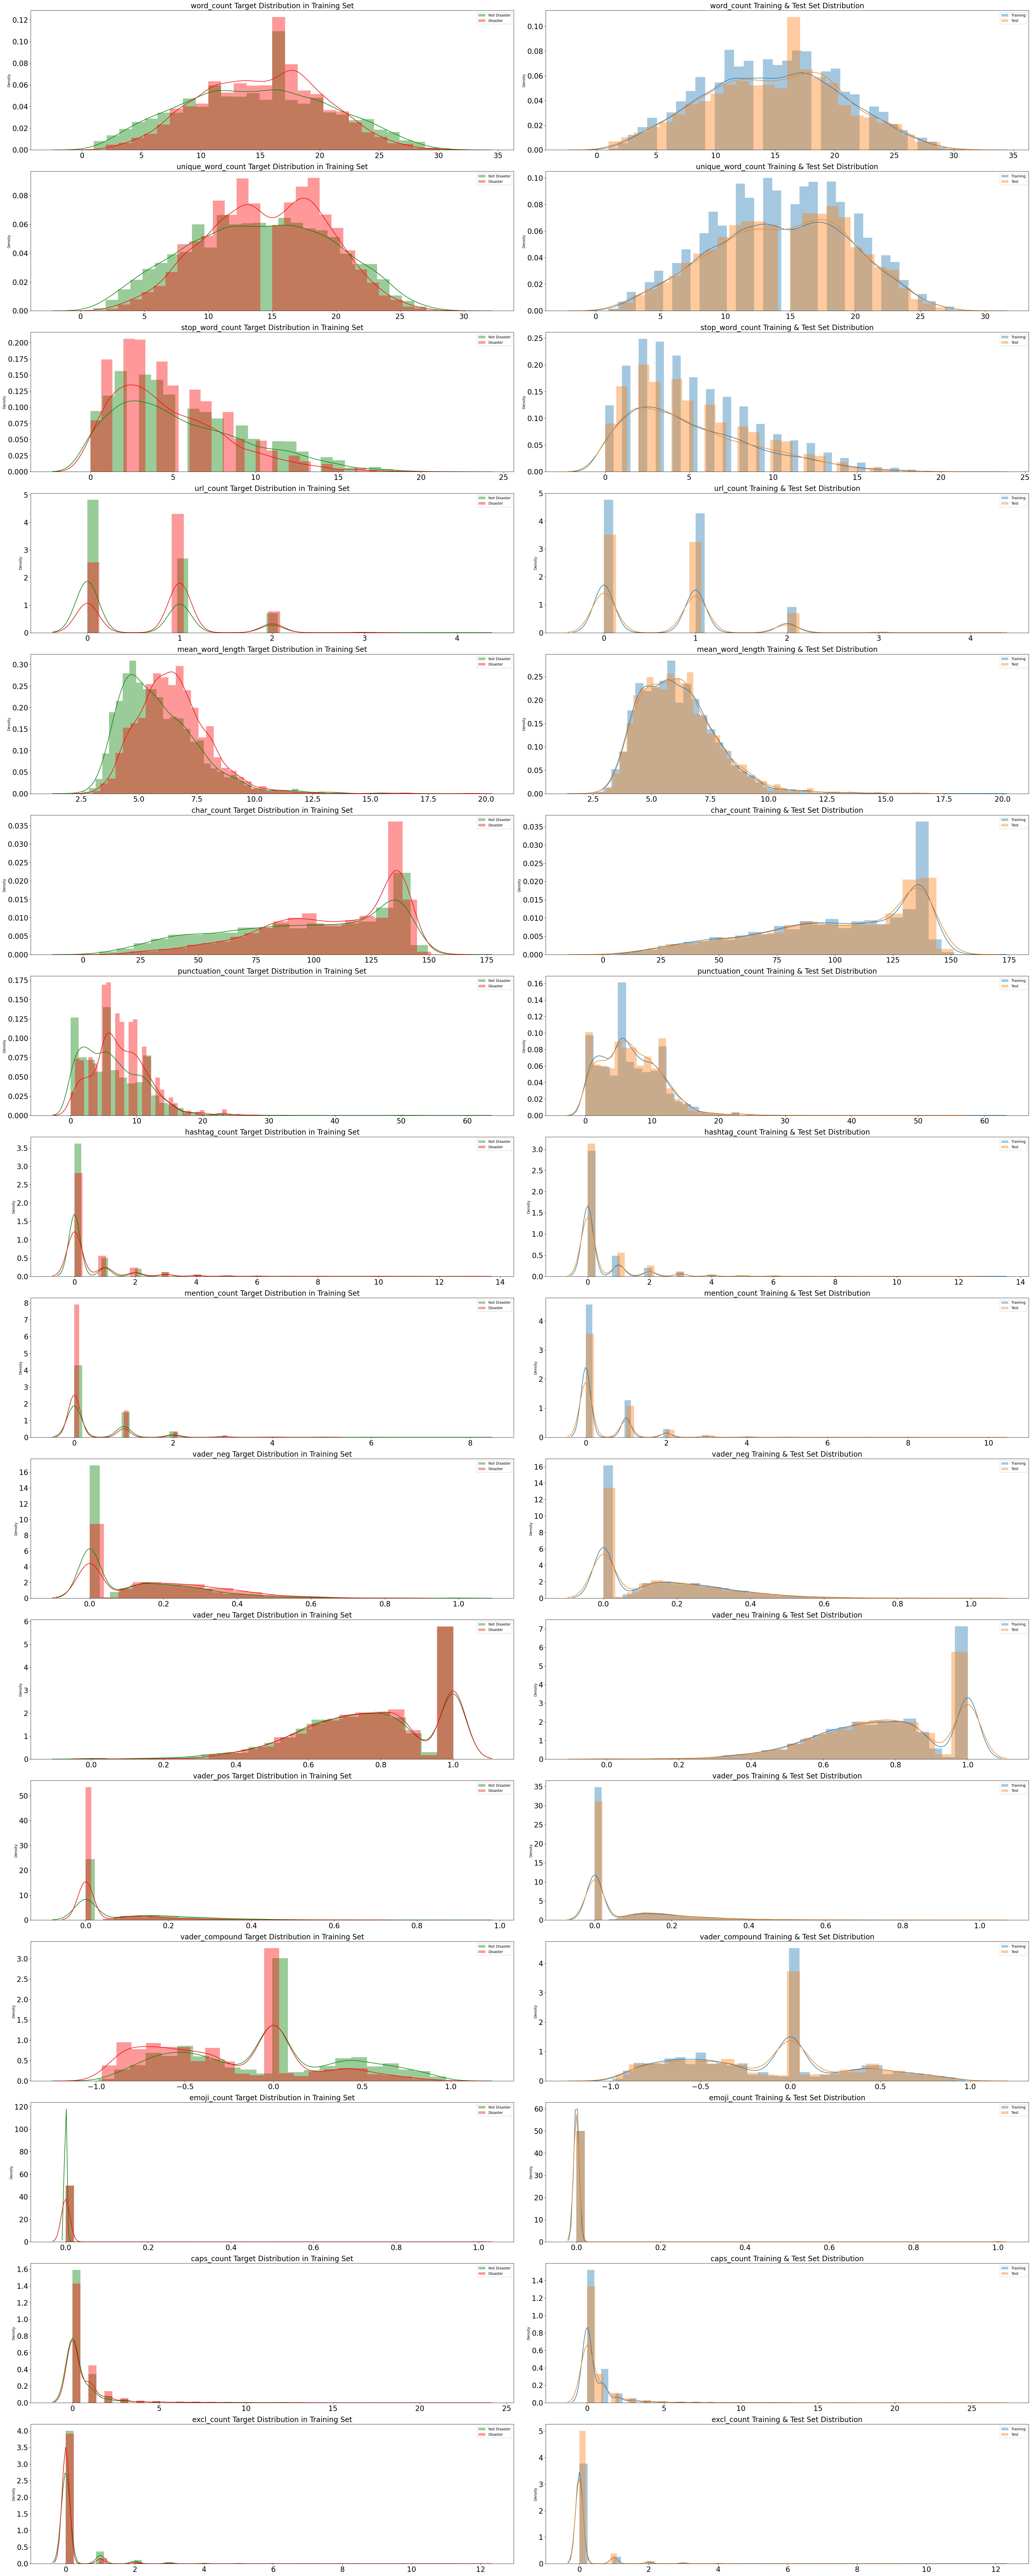

In [7]:
df_train = add_all_text_features(df_train)
df_test = add_all_text_features(df_test)

plot_metafeatures_distribution(df_train, df_test)

### Feature Selection

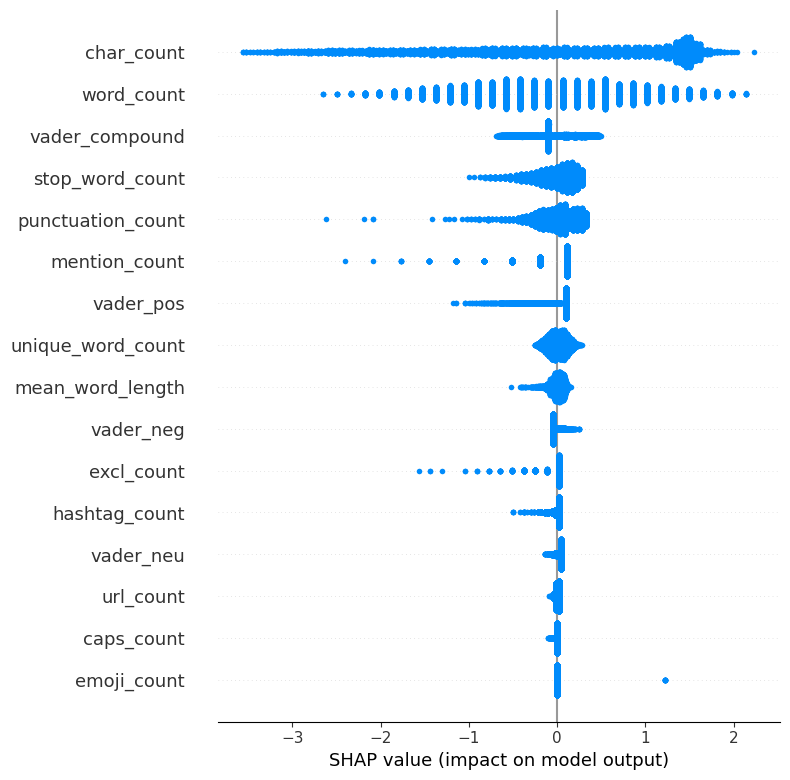

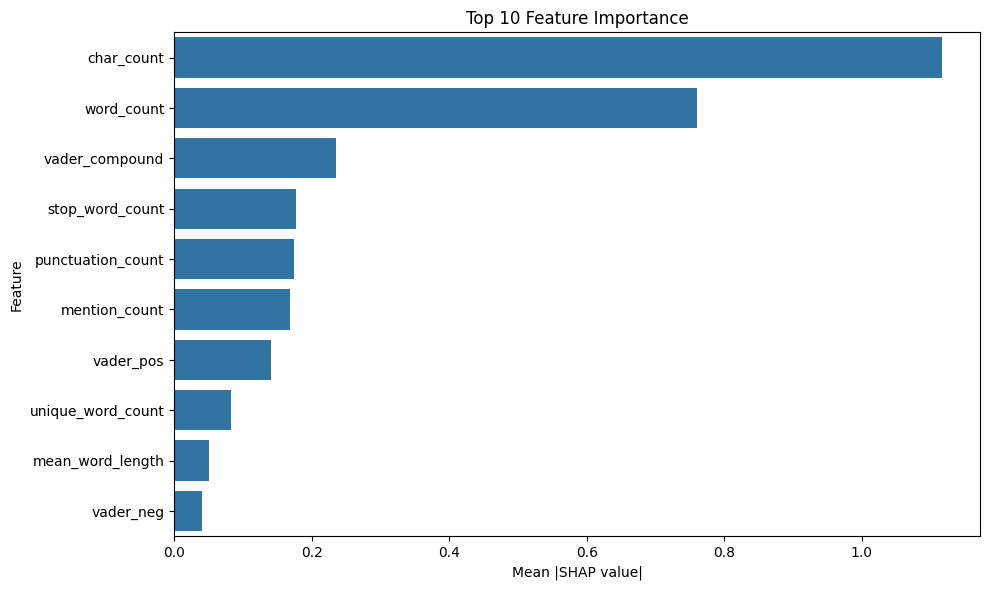


Feature Importance:
              feature  importance
5          char_count    1.116354
0          word_count    0.760353
12     vader_compound    0.234804
2     stop_word_count    0.176735
6   punctuation_count    0.173820
8       mention_count    0.168243
11          vader_pos    0.140890
1   unique_word_count    0.083147
4    mean_word_length    0.051261
9           vader_neg    0.040094
15         excl_count    0.034303
7       hashtag_count    0.029511
10          vader_neu    0.026501
3           url_count    0.016947
14         caps_count    0.004770
13        emoji_count    0.001612


In [8]:
analyzer = FeatureImportanceAnalyzer(
    model_type='logistic_regression',
    random_state=42
)

analyzer.fit(
    X=df_train[METAFEATURES],
    y=df_train['target']
)

analyzer.plot_summary(max_display=20)

analyzer.plot_feature_importance(top_n=10)

importance_df = analyzer.get_feature_importance()
print("\nFeature Importance:")
print(importance_df)

### Text processing

#### Clean text

In [9]:
df_train = preprocess_dataframe(df_train, DEFAULT_TEXT_COLUMN)
df_test = preprocess_dataframe(df_test, DEFAULT_TEXT_COLUMN)

#### Analize n-grams

In [10]:
(
    df_disaster_unigrams, df_nondisaster_unigrams,
    df_disaster_bigrams, df_nondisaster_bigrams,
    df_disaster_trigrams, df_nondisaster_trigrams
) = analyze_ngrams(df_train)

## Model Evaluation

In [11]:
# Prepare data for model training
X = df_train[DEFAULT_TEXT_COLUMN].values
y = df_train[DEFAULT_TARGET_COLUMN].values

In [12]:
pipeline = create_text_classification_pipeline(
        vectorizer_params={
            'max_features': 5000,
            'ngram_range': (1, 2),
            'min_df': 2,
            'max_df': 0.95,
            'sublinear_tf': True
        },
        classifier_params={
            'C': 1.0,
            'max_iter': 1000,
            'random_state': 42
        },
        n_jobs=-1
    )

trainer = ModelTrainer(test_size=0.2, random_state=42, n_jobs=-1)
    
cv_scores = trainer.cross_validate(
        model=pipeline,
        X=X,
        y=y,
        cv=5,
        scoring='f1',
        stratified=True
    )

print(f"F1-scores: {cv_scores.round(4)}")
print(f"Mean F1-score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

F1-scores: [0.7437 0.7414 0.7389 0.754  0.7551]
Mean F1-score: 0.7466 ± 0.0066


### TF-IDF and LogReg optimization

In [13]:
def pipeline_factory(params):
    return create_text_classification_pipeline(
        vectorizer_params={
            'max_features': params['max_features'],
            'ngram_range': params['ngram_range'],
            'min_df': params['min_df'],
            'max_df': params['max_df']
        },
        classifier_params={
            'C': params['C'],
            'max_iter': params['max_iter'],
            'class_weight': params['class_weight'],
            'random_state': 42
        },
        n_jobs=-1
    )

def param_space(trial):
    # TF-IDF parameters
    max_features = trial.suggest_int('max_features', 1000, 15000, step=1000)
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)])
    min_df = trial.suggest_int('min_df', 1, 10)
    max_df = trial.suggest_float('max_df', 0.7, 1.0)
    
    # Logistic Regression parameters
    C = trial.suggest_float('C', 1e-3, 100.0, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag'])
    max_iter = trial.suggest_int('max_iter', 100, 2000, step=100)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    l1_ratio = None
    # l1_ratio only for penalty='elasticnet' and solver='saga'
    if penalty == 'elasticnet' and solver == 'saga':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    
    params = {
        'max_features': max_features,
        'ngram_range': ngram_range,
        'min_df': min_df,
        'max_df': max_df,
        'C': C,
        'penalty': penalty,
        'solver': solver,
        'max_iter': max_iter,
        'class_weight': class_weight
    }
    if l1_ratio is not None:
        params['l1_ratio'] = l1_ratio
    return params

In [14]:
trainer = ModelTrainer(test_size=0.2, random_state=42, n_jobs=-1)
nested_scores = trainer.nested_optuna_cv(
    X, y,
    pipeline_factory=pipeline_factory,
    param_space=param_space,
    n_trials=100,
    inner_cv=3,
    outer_cv=5,
    scoring='f1',
    random_state=42
)
print(f"\nNested Optuna CV F1 scores: {nested_scores.round(4)}")
print(f"Mean F1: {nested_scores.mean():.4f} ± {nested_scores.std():.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Fold 1 F1: 0.7944
Best params: {'max_features': 5000, 'ngram_range': (1, 1), 'min_df': 4, 'max_df': 0.95500643788997, 'C': 1.42164570679323, 'penalty': 'none', 'solver': 'saga', 'max_iter': 500, 'class_weight': 'balanced'}


  0%|          | 0/100 [00:00<?, ?it/s]

Fold 2 F1: 0.7976
Best params: {'max_features': 9000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.7898876103044401, 'C': 0.7761079402327131, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 200, 'class_weight': 'balanced'}


  0%|          | 0/100 [00:00<?, ?it/s]

Fold 3 F1: 0.7897
Best params: {'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 1, 'max_df': 0.8120609957449978, 'C': 1.6463655852118748, 'penalty': 'none', 'solver': 'liblinear', 'max_iter': 200, 'class_weight': 'balanced'}


  0%|          | 0/100 [00:00<?, ?it/s]

Fold 4 F1: 0.8016
Best params: {'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 1, 'max_df': 0.9122182331158496, 'C': 1.356390182738621, 'penalty': 'elasticnet', 'solver': 'liblinear', 'max_iter': 500, 'class_weight': 'balanced'}


  0%|          | 0/100 [00:00<?, ?it/s]

Fold 5 F1: 0.8009
Best params: {'max_features': 9000, 'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.9633016909180566, 'C': 4.232550235112086, 'penalty': 'none', 'solver': 'saga', 'max_iter': 1900, 'class_weight': 'balanced'}

Nested Optuna CV F1 scores: [0.7944 0.7976 0.7897 0.8016 0.8009]
Mean F1: 0.7969 ± 0.0044


In [15]:
study, best_params = find_optimal_text_classifier_params(
    X=X,
    y=y,
    pipeline_factory=pipeline_factory,
    param_space=param_space,
    n_trials=100,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    show_progress_bar=True
)

  0%|          | 0/100 [00:00<?, ?it/s]


Optimal hyperparameters:
max_features: 4000
ngram_range: (1, 1)
min_df: 3
max_df: 0.9220949699963132
C: 1.4490668024989475
penalty: elasticnet
solver: newton-cg
max_iter: 1900
class_weight: balanced

Best f1 score: 0.7663
